In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
test = pd.read_csv('drive/My Drive/ASONAM17_Damage_Image_Dataset/nepal.test', encoding='latin1')
train  = pd.read_csv('drive/My Drive/ASONAM17_Damage_Image_Dataset/nepal.train', encoding='latin1')
dev = pd.read_csv('drive/My Drive/ASONAM17_Damage_Image_Dataset/nepal.dev', encoding='latin1')

In [ ]:
train.columns=["Image"]
test.columns=["Image"]

dev.columns=["Image"]

In [ ]:
def extract_paths_and_labels(df):
    paths = []
    labels = []
    for row in df["Image"]:
        parts = row.split(" ")
        paths.append(parts[0])
        labels.append(int(parts[-1]))
    return paths, labels

In [ ]:
train_paths, train_labels = extract_paths_and_labels(train)
test_paths, test_labels = extract_paths_and_labels(test)
dev_paths, dev_labels = extract_paths_and_labels(dev)

In [ ]:
import os
path_train=os.listdir('drive/MyDrive/ASONAM17_Damage_Image_Dataset/nepal_eq')

In [ ]:

pre_path='drive/MyDrive/ASONAM17_Damage_Image_Dataset/'
def create_dataset(paths, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Load and preprocess images in parallel
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(pre_path + path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, label

In [ ]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(train_labels, num_classes=3)
Y_test = to_categorical(test_labels, num_classes=3)
Y_dev = to_categorical(dev_labels, num_classes=3)

In [ ]:

train_dataset = create_dataset(train_paths, Y_train)
dev_dataset = create_dataset(dev_paths, Y_dev)
test_dataset = create_dataset(test_paths, Y_test)

In [ ]:
module_url = "https://tfhub.dev/google/bit/m-r101x1/1"
bit_model = hub.KerasLayer(module_url, trainable=False)


In [ ]:
# x = GlobalAveragePooling2D()(bit_model.output)
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
bit_output = bit_model(input_layer)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [ ]:
output = tf.keras.layers.Dense(3, activation='softmax')(bit_output)

In [ ]:
model = Model(inputs=input_layer, outputs=output)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, validation_data=dev_dataset, epochs=15,initial_epoch=11)

Epoch 12/15
359/359 [==============================] - 579s 2s/step - loss: 0.4174 - accuracy: 0.8622 - val_loss: 0.6675 - val_accuracy: 0.8238
Epoch 13/15
359/359 [==============================] - ETA: 0s - loss: 0.4103 - accuracy: 0.8657

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

120/120 [==============================] - 147s 1s/step - loss: 0.6405 - accuracy: 0.8253
Test Loss: 0.6405234336853027
Test Accuracy: 0.8253469467163086


In [ ]:
train_paths, train_labels = extract_paths_and_labels(train)
test_paths, test_labels = extract_paths_and_labels(test)
dev_paths, dev_labels = extract_paths_and_labels(dev)

In [ ]:
predictions = model.predict(test_dataset)

120/120 [==============================] - 147s 1s/step


In [ ]:
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
true_labels = []
for images, labels in test_dataset:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, predicted_labels)

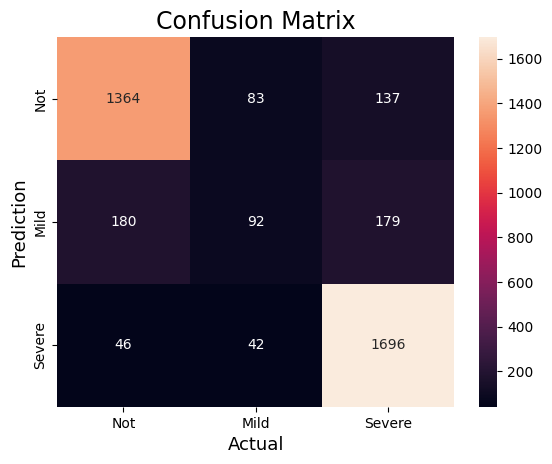

In [ ]:
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Not', 'Mild', 'Severe'],
            yticklabels=['Not', 'Mild', 'Severe'])
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1584
           1       0.42      0.20      0.28       451
           2       0.84      0.95      0.89      1784

    accuracy                           0.83      3819
   macro avg       0.71      0.67      0.68      3819
weighted avg       0.80      0.83      0.81      3819



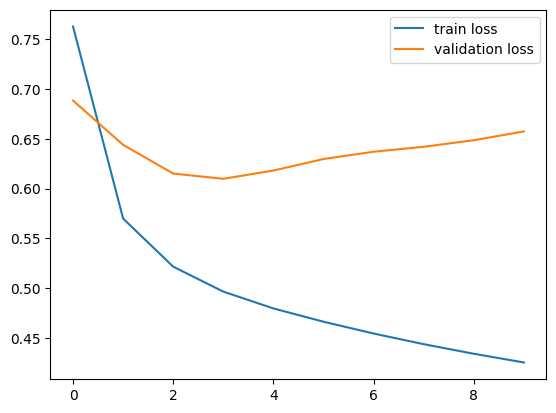

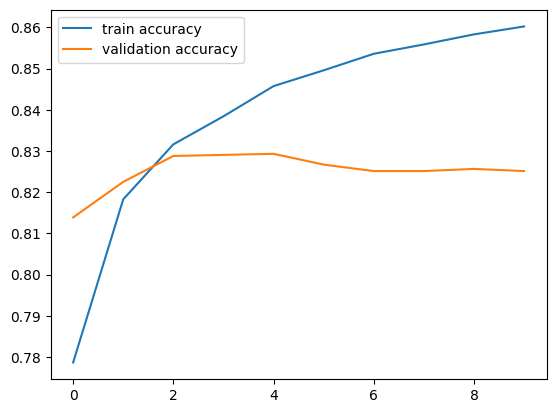

In [ ]:
h = history

plt.plot(h.history['loss'], label = 'train loss')
plt.plot(h.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

plt.plot(h.history['accuracy'], label = 'train accuracy')
plt.plot(h.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()